In [1]:
using OffsetArrays

In [2]:
function BP_th(H, tus)
    p1 = prod(1 .+ tus)*exp(H)
    p2 = prod(1 .- tus)*exp(-H)
    if p1+p2==0
        println("conflicting messages in BP_th")
    end
    th = (p1-p2)/(p1+p2)
end

function BP_tu(s, ths)
    tu = s*prod(ths)
end

BP_tu (generic function with 1 method)

In [3]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    ind = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        ind += 1
        σs[ind] = sig
        if prod(sig) == s
            ν[ind] += prod(1 .+ sig.*ths_0)
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

In [4]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [5]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        popP_RS = fill(0.0, 1:popsize),
        popQ_RS = fill(0.0, 1:popsize),
        q0 = fill(NaN, 1:maxiter)
    )

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    
    @showprogress for t = 1:maxiter
        
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu(s, ths)
        end
        
        q0[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ_RS[ind_tus]
            popP_RS[i] = BP_th(H, tus)
            
            q0[t]+=popP_RS[i]^2
        end
        
        q0[t] = q0[t]/length(popP_RS)
    end
    popP_RS, popQ_RS, q0
#    popP_RS, popQ_RS
end

RS (generic function with 1 method)

In [6]:
function init_pop(pop_RS, ϵ)
    pop = fill(NaN, -1:1, 1:popsize)
    pop[0,:]=popP_RS
    pop[1,:].=ϵ
    pop[-1,:].=-ϵ
    pop
end
function init_pop_alternative(pop_RS, ϵ)
    pop = fill(NaN, -1:1, 1:popsize)
    pop[0,:]=popP_RS
    for i=1:popsize
        pop[1,i]=(rand()<ϵ ? 1.0 : pop[0,i])
        pop[-1,i]=(rand()<ϵ ? -1.0 : pop[0,i])
    end
    pop
end

init_pop_alternative (generic function with 1 method)

In [92]:
function checkRS(popP)
    q0=0.0; q1=0.0
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        #@show th, th[0], th[1], th[-1]
        q0 += th[0]^2
        q1 += 0.5*th[1]*(1.0+th[0]) - 0.5*th[-1]*(1.0 - th[0])
    end
    q1= q1/size(popP, 2); q0=q0/size(popP, 2)
    q0, q1, q1-q0
end

checkRS (generic function with 1 method)

In [8]:
function checkHardFields(popP)
    pHF = 0.0;
    p1=0.0; pm1=0.0;
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        pHF += 0.5*(1.0 + th[0])*atanh(th[1])^2 + 0.5*(1.0 - th[0])*atanh(th[-1])^2
        p1 += (th[1] == 1.0 ? 1.0 : 0.0)
        pm1 += (th[-1] == -1.0 ? 1.0 : 0.0)
    end
    pHF=pHF/size(popP, 2)
    p1=p1/size(popP, 2)
    pm1=pm1/size(popP, 2)
    pHF, p1, pm1
end

checkHardFields (generic function with 1 method)

In [9]:
function checkHardFields_almostfrozen(popP, xmin)
    p1=0.0; pm1=0.0;
    for ind=1:size(popP, 2)
        th = popP[:,ind]
#        p1 += (th[1] > 1.0-xmin ? 1.0 : 0.0)
#        pm1 += (th[-1] < -1.0+xmin ? 1.0 : 0.0)
        p1 += (1.0 - th[1] < xmin ? 1.0 : 0.0)
        pm1 += (1.0 + th[-1] < xmin ? 1.0 : 0.0)
    end
    p1=p1/size(popP, 2)
    pm1=pm1/size(popP, 2)
    p1, pm1
end

checkHardFields_almostfrozen (generic function with 1 method)

In [10]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        popP = init_pop(popP_RS, 0.9),
        popQ = init_pop(popQ_RS, 0.9),
        q0=fill(NaN, 1:maxiter),
        V=fill(NaN, 1:maxiter),
        p1=fill(NaN, 1:maxiter),
        pm1=fill(NaN, 1:maxiter),
        xmin=10^(-20)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu(s, ths[0,:])
            #@show ind_ths, s
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[1,i] = BP_tu(s, elts)

            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[-1,i] = BP_tu(s, elts)
        end

        q0[t]=0.0; V[t]=0.0; p1[t]=0.0; pm1[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ[:,ind_tus]
            #@show ind_tus
            popP[0,i] = BP_th(H, tus[0,:])
            popP[-1,i] = BP_th(H, tus[-1,:])
            popP[1,i] = BP_th(H, tus[1,:])
            
            q0[t]+= popP[0,i]^2
            V[t]+= 0.5*popP[1,i]*(1.0+popP[0,i]) - 0.5*popP[-1,i]*(1.0 - popP[0,i])
            #p1[t]+=(popP[1,i] == 1.0 ? 1.0 : 0.0)
            #pm1[t]+=(popP[-1,i] == -1.0 ? 1.0 : 0.0)
            p1[t]+=(1.0 - popP[1,i] < xmin ? 1.0 : 0.0)
            pm1[t]+=(1.0 + popP[-1,i] < xmin ? 1.0 : 0.0)
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
        p1[t] = p1[t]/size(popP, 2)
        pm1[t] = pm1[t]/size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V, p1, pm1
end

RSB_entropic_m1 (generic function with 1 method)

In [11]:
function RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        popP = init_pop(popP_RS, 0.9),
        popQ = init_pop(popQ_RS, 0.9),
        q0=fill(NaN, 1:maxiter),
        V=fill(NaN, 1:maxiter),
        p1=fill(NaN, 1:maxiter),
        pm1=fill(NaN, 1:maxiter),
        xmin=10^(-10), ntry=10
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            res1=10; resm1=-10; n=0; res0=0.0
            while n<ntry && (1.0 - res1 < xmin || 1.0 + resm1 < xmin)
                n+=1
                
                k = sample(eachindex(K1), wK1)
                ind_ths = rand(1:popsize, k)
                ths = popP[:,ind_ths]            
                s = rand((-1,1))
                res0 = BP_tu(s, ths[0,:])

                ν = fill(0.0, 1:2^k)
                σs = fill(tuple(fill(NaN, k)...), 1:2^k)
                ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
                wν = weights(ν)
                ind = sample(eachindex(ν), wν)
                σ = convert.(Int64, σs[ind])
                elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
                res1 = BP_tu(s, elts)
                

                ν = fill(0.0, 1:2^k)
                σs = fill(tuple(fill(NaN, k)...), 1:2^k)
                ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
                wν = weights(ν)
                ind = sample(eachindex(ν), wν)
                σ = convert.(Int64, σs[ind])
                elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
                resm1 = BP_tu(s, elts)
            end
            popQ[0,i] = res0; popQ[1,i] = res1; popQ[-1,i]=resm1
        end

        q0[t]=0.0; V[t]=0.0; p1[t]=0.0; pm1[t]=0.0
        
        for i = 1:popsize
            res1=10; resm1=-10; n=0; res0=0.0
            while n<ntry && (1.0 - res1 < xmin || 1.0 + resm1 < xmin)
                n+=1
                d = sample(eachindex(Λ1), wΛ1)
                ind_tus = rand(1:popsize, d)
                tus = popQ[:,ind_tus]
                res0 = BP_th(H, tus[0,:])
                resm1 = BP_th(H, tus[-1,:])
                res1 = BP_th(H, tus[1,:])
            end
            popP[0,i] = res0; popP[-1,i]=resm1; popP[1,i]=res1
            
            q0[t]+= popP[0,i]^2
            V[t]+= 0.5*popP[1,i]*(1.0+popP[0,i]) - 0.5*popP[-1,i]*(1.0 - popP[0,i])
            p1[t]+=(1.0 - popP[1,i] < xmin ? 1.0 : 0.0)
            pm1[t]+=(1.0 + popP[-1,i] < xmin ? 1.0 : 0.0)
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
        p1[t] = p1[t]/size(popP, 2)
        pm1[t] = pm1[t]/size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V, p1, pm1
end

RSB_entropic_m1_almostfrozen (generic function with 1 method)

Test removing almost frozen variables
---

In [164]:
f3 = 0.1
H=3.0
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
popP_RS = fill(NaN, 1:popsize)
popQ_RS = fill(NaN, 1:popsize)
popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [167]:
popP_init = init_pop(popP_RS, 0.95)
checkRS(popP_init)

(0.8364687593886987, 0.9499999999999894, 0.11353124061129072)

In [168]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
p1=fill(NaN, 1:maxiter)
pm1=fill(NaN, 1:maxiter)
maxiter=10^3
xmin=10^(-50)
popP = init_pop(popP_RS, 0.9)
popQ = init_pop(popQ_RS, 0.9)
popP, popQ, q0, V, p1, pm1 = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ, xmin=xmin)
popP

Progress: 100%|█████████████████████████████████████████| Time: 0:02:06


3×10000 OffsetArray(::Array{Float64,2}, -1:1, 1:10000) with eltype Float64 with indices -1:1×1:10000:
 0.96291   0.495191  0.683397  0.996268  …  0.999999  0.939276  0.664621
 0.962907  0.495186  0.683391  0.996267     0.999999  0.939273  0.664604
 0.96291   0.495191  0.683397  0.996268     0.999999  0.939276  0.664621

In [169]:
q0_af=fill(NaN, 1:maxiter)
V_af=fill(NaN, 1:maxiter)
p1_af=fill(NaN, 1:maxiter)
pm1_af=fill(NaN, 1:maxiter)
maxiter=10^3
xmin= 10^(-50)
ntry=20
popP_af = init_pop(popP_RS, 0.9)
popQ_af = init_pop(popQ_RS, 0.9)
popP_af, popQ_af, q0_af, V_af, p1_af, pm1_af = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP_af, popQ=popQ_af, xmin=xmin, ntry=ntry)
popP_af

Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


3×10000 OffsetArray(::Array{Float64,2}, -1:1, 1:10000) with eltype Float64 with indices -1:1×1:10000:
 0.999942  0.999982  0.992987  …  0.830683  -0.959553  0.995021  1.0
 0.999942  0.999982  0.992986     0.830803  -0.959554  0.99502   1.0
 0.999942  0.999982  0.992987     0.830683  -0.959553  0.995021  1.0

In [170]:
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 0.54, 1.0]
fit(Histogram, 1.0 .- popP_af[1,:], bins)

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 1.0000000000000033e-60, 1.0000000000000017e-30, 1.0000000000000011e-20, 1.0000000000000009e-15, 1.0000000000000006e-10, 0.1, 0.5, 0.54, 1.0]
weights: [0, 0, 0, 0, 14, 7015, 1013, 75, 533]
closed: left
isdensity: false

In [171]:
fit(Histogram, 1.0 .+ popP_af[-1,:], bins)

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 1.0000000000000033e-60, 1.0000000000000017e-30, 1.0000000000000011e-20, 1.0000000000000009e-15, 1.0000000000000006e-10, 0.1, 0.5, 0.54, 1.0]
weights: [0, 0, 0, 0, 0, 528, 380, 27, 415]
closed: left
isdensity: false

In [172]:
fit(Histogram, 1.0 .- popP[1,:], bins)

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 1.0000000000000033e-60, 1.0000000000000017e-30, 1.0000000000000011e-20, 1.0000000000000009e-15, 1.0000000000000006e-10, 0.1, 0.5, 0.54, 1.0]
weights: [0, 0, 0, 0, 13, 7056, 874, 43, 550]
closed: left
isdensity: false

In [173]:
fit(Histogram, 1.0 .+ popP[-1,:], bins)

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 1.0000000000000033e-60, 1.0000000000000017e-30, 1.0000000000000011e-20, 1.0000000000000009e-15, 1.0000000000000006e-10, 0.1, 0.5, 0.54, 1.0]
weights: [0, 0, 0, 0, 0, 609, 417, 34, 404]
closed: left
isdensity: false

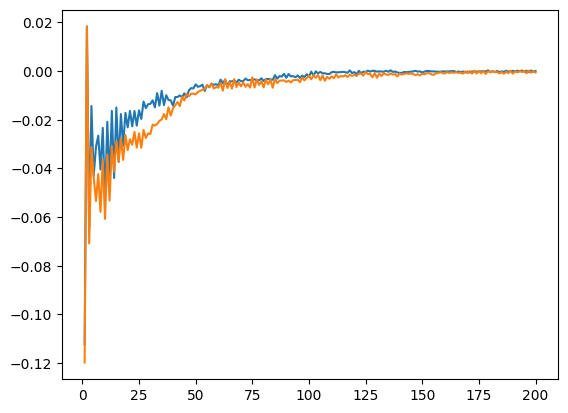

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa90bbde1d0>

In [175]:
using PyPlot
range = 1:200
#plot(range, p1[range])
plot(range, V[range])
plot(range, V_af[range])


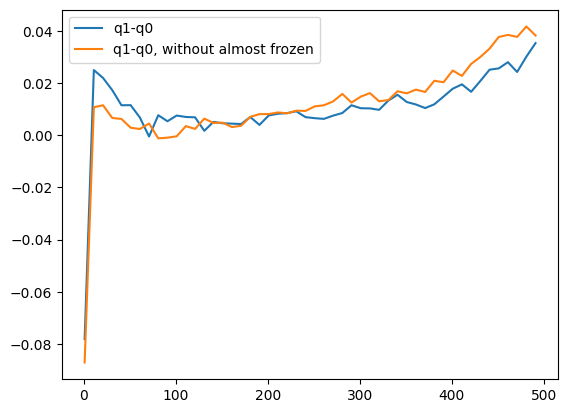

PyObject <matplotlib.legend.Legend object at 0x7fa90e5cda20>

In [139]:
using PyPlot
range = 1:10:500
#plot(range, q0[range], label="q0")
#plot(range, V[range] + q0[range], label="q1")
plot(range, V[range], label="q1-q0")
#plot(range, q0_af[range], label="q0, without almost frozen")
#plot(range, V_af[range] .+ q0_af[range], label="q1, without almost frozen")
plot(range, V_af[range], label="q1-q0, without almost frozen")
legend()

In [136]:
using Statistics
cut = 500
mean_q0 = mean(q0[cut:maxiter]); std_q0 = std(q0[cut:maxiter])
mean_V = mean(V[cut:maxiter]); std_V = std(V[cut:maxiter])
mean_q0_af = mean(q0_af[cut:maxiter]); std_q0_af = std(q0_af[cut:maxiter])
mean_V_af = mean(V_af[cut:maxiter]); std_V_af = std(V_af[cut:maxiter])
mean_q0, mean_q0_af

(0.8536322903862288, 0.8531825870916294)

In [137]:
std_q0, std_q0_af

(0.006062936476847918, 0.0063732992909228655)

Some tests
---

In [23]:
using Unzip

With $f3=0$
---

In [24]:
f3 = 0.0
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 0.0:2.0:4.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0_pop1e4_af = Hs
q0_1_f0_pop1e4_af = q0s_1
q0_f0_pop1e4_af = q0s
V_f0_pop1e4_af = Vs
p1_f0_pop1e4_af = p1
pm1_f0_pop1e4_af = pm1
Hist_f0_pop1e4_af = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, Vs[maxiter, i], p1[maxiter, i]) = (0.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:20


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, Vs[maxiter, i], p1[maxiter, i]) = (4.0, 0.0, 0.0)


8×3 OffsetArray(::Array{Float64,2}, 1:8, 1:3) with eltype Float64 with indices 1:8×1:3:
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0    64.0
 0.0  6451.0  7279.0
 0.0  1405.0   743.0
 0.0  1024.0   766.0

In [25]:
f3 = 0.0
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 0.0:2.0:4.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0_pop1e4 = Hs
q0_1_f0_pop1e4 = q0s_1
q0_f0_pop1e4 = q0s
V_f0_pop1e4 = Vs
p1_f0_pop1e4 = p1
pm1_f0_pop1e4 = pm1
Hist_f0_pop1e4 = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


(H, Vs[maxiter, i], p1[maxiter, i]) = (0.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


(H, Vs[maxiter, i], p1[maxiter, i]) = (4.0, 0.0, 0.0)


8×3 OffsetArray(::Array{Float64,2}, 1:8, 1:3) with eltype Float64 with indices 1:8×1:3:
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0     0.0
 0.0     0.0    70.0
 0.0  6455.0  7290.0
 0.0  1489.0   737.0
 0.0  1019.0   778.0

With $f_3=0.1$
---

In [108]:
f3 = 0.1
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 0.0:2.0:6.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop(popP_RS, 0.99);
    popQ = init_pop(popQ_RS, 0.99);
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0p1_pop1e4_af = Hs
q0_1_f0p1_pop1e4_af = q0s_1
q0_f0p1_pop1e4_af = q0s
V_f0p1_pop1e4_af = Vs
p1_f0p1_pop1e4_af = p1
pm1_f0p1_pop1e4_af = pm1
Hist_f0p1_pop1e4_af = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:20


(H, Vs[maxiter, i], p1[maxiter, i]) = (0.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, Vs[maxiter, i], p1[maxiter, i]) = (4.0, -0.01052051794998099, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, Vs[maxiter, i], p1[maxiter, i]) = (6.0, -0.05465023103653954, 0.0)


8×4 OffsetArray(::Array{Float64,2}, 1:8, 1:4) with eltype Float64 with indices 1:8×1:4:
 0.0     0.0     0.0     0.0
 0.0     0.0     0.0     0.0
 0.0     0.0     0.0     0.0
 0.0     0.0     2.0    77.0
 0.0     0.0   179.0  1276.0
 0.0  6438.0  7261.0  6546.0
 0.0  1409.0   727.0   390.0
 0.0   824.0   430.0   318.0

In [109]:
f3 = 0.1
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 0.0:2.0:6.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop(popP_RS, 0.99);
    popQ = init_pop(popQ_RS, 0.99);
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ)
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0p1_pop1e4 = Hs
q0_1_f0p1_pop1e4 = q0s_1
q0_f0p1_pop1e4 = q0s
V_f0p1_pop1e4 = Vs
p1_f0p1_pop1e4 = p1
pm1_f0p1_pop1e4 = pm1
Hist_f0p1_pop1e4 = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


(H, Vs[maxiter, i], p1[maxiter, i]) = (0.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 4.440892098500626e-16, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


(H, Vs[maxiter, i], p1[maxiter, i]) = (4.0, -0.013692140729182234, 0.0001)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


(H, Vs[maxiter, i], p1[maxiter, i]) = (6.0, -0.06423803757348634, 0.0095)


8×4 OffsetArray(::Array{Float64,2}, 1:8, 1:4) with eltype Float64 with indices 1:8×1:4:
 0.0     0.0     1.0    95.0
 0.0     0.0     0.0     0.0
 0.0     0.0     0.0     0.0
 0.0     0.0     1.0    64.0
 0.0     0.0   206.0  1311.0
 0.0  6227.0  7335.0  6406.0
 0.0  1541.0   635.0   500.0
 0.0   891.0   358.0   266.0

In [111]:
V_f0p1_pop1e4[, i]+q0_f0p1_pop1e4[1, i]

0.7762317801820772

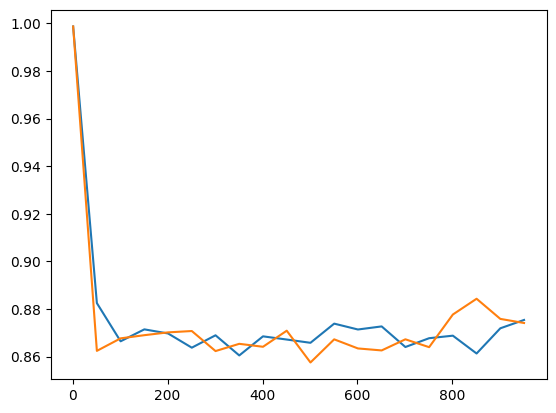

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa90bf5c5f8>

In [154]:
range=1:50:1000
i=3
plot(range, q0_1_f0p1_pop1e4[range, i])
plot(range, q0_1_f0p1_pop1e4_af[range, i])

With $f_3=0.2$
---

In [155]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 1.0:0.2:2.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0p2_pop1e4_af = Hs
q0_1_f0p2_pop1e4_af = q0s_1
q0_f0p2_pop1e4_af = q0s
V_f0p2_pop1e4_af = Vs
p1_f0p2_pop1e4_af = p1
pm1_f0p2_pop1e4_af = pm1
Hist_f0p2_pop1e4_af = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:16


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.2, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.4, 2.220446049250313e-16, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.6, 3.2955860262973147e-12, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:09


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.8, 0.26583304765729865, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 0.24883677586845943, 0.0)


8×6 OffsetArray(::Array{Float64,2}, 1:8, 1:6) with eltype Float64 with indices 1:8×1:6:
    0.0     0.0     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0   243.0   353.0
    0.0     0.0     0.0     0.0  2691.0  2973.0
 2784.0  3862.0  4689.0  5473.0  7038.0  6659.0
 4395.0  3450.0  2880.0  2147.0    14.0    13.0
 1707.0  1426.0  1121.0  1027.0     2.0     0.0

In [156]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
xmin=10^(-50)
ntry=20

Hs = 1.0:0.2:2.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1=fill(NaN, 1:maxiter, eachindex(Hs))
pm1=fill(NaN, 1:maxiter, eachindex(Hs))
bins = [0.0, 10^(-60), 10^(-30), 10^(-20), 10^(-15), 10^(-10), 0.1, 0.5, 1.0]
HistPopP1s = fill(NaN, 1:(length(bins)-1), eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    #popP, popQ, q0s[:,i], Vs[:,i], p1[:,i], pm1[:,i] = RSB_entropic_m1_almostfrozen(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, xmin=xmin, ntry=ntry)    
    
    HistPopP1s[:,i] = fit(Histogram, 1.0 .- popP[1,:], bins).weights
    
    @show H, Vs[maxiter, i], p1[maxiter, i]
end
H_f0p2_pop1e4 = Hs
q0_1_f0p2_pop1e4 = q0s_1
q0_f0p2_pop1e4 = q0s
V_f0p2_pop1e4 = Vs
p1_f0p2_pop1e4 = p1
pm1_f0p2_pop1e4 = pm1
Hist_f0p2_pop1e4 = HistPopP1s

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.0, 0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.2, -2.220446049250313e-16, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.4, 2.220446049250313e-16, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.6, 2.823297151621773e-13, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


(H, Vs[maxiter, i], p1[maxiter, i]) = (1.8, 0.25927293903795867, 1.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


(H, Vs[maxiter, i], p1[maxiter, i]) = (2.0, 0.23478279210124342, 1.0)


8×6 OffsetArray(::Array{Float64,2}, 1:8, 1:6) with eltype Float64 with indices 1:8×1:6:
    0.0     0.0     0.0     0.0  10000.0  10000.0
    0.0     0.0     0.0     0.0      0.0      0.0
    0.0     0.0     0.0     0.0      0.0      0.0
    0.0     0.0     0.0     0.0      0.0      0.0
    0.0     0.0     0.0     0.0      0.0      0.0
 2783.0  3782.0  4682.0  5351.0      0.0      0.0
 4419.0  3533.0  2839.0  2217.0      0.0      0.0
 1742.0  1420.0  1167.0  1083.0      0.0      0.0

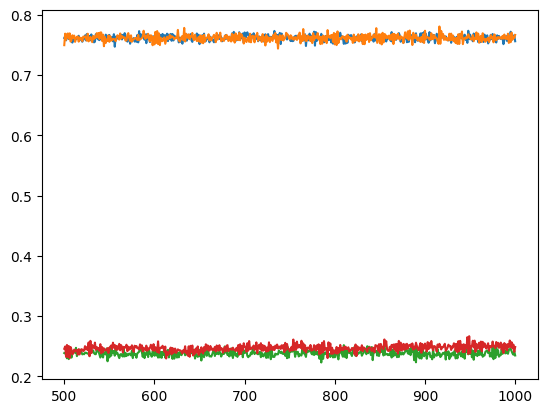

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa90bc9a748>

In [163]:
i=6
range=500:1000
plot(range, q0_1_f0p2_pop1e4[range, i])
plot(range, q0_1_f0p2_pop1e4_af[range, i])
plot(range, V_f0p2_pop1e4[range, i])
plot(range, V_f0p2_pop1e4_af[range, i])

Rigidity threshold (to be corrected)
---

In [30]:
function HF_fraction(Λ, K;
        init_p=1.0,
        maxiter=1000)
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    
    p=init_p
    for t = 1:maxiter
        q = sum(K1[k]*p^k for k in eachindex(K1))
        p = 1-sum(Λ1[d]*(1-q)^d for d in eachindex(Λ1))
    end
    p
end

HF_fraction (generic function with 1 method)

In [31]:
f3 = 0.405
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
HF_fraction(Λ, K, init_p=0.99, maxiter=5000)

1.1102230246251565e-16